## There are 4 parts of experiment for the project in this documnets


1. Parse Raw Text to Vector Space Model
2. Clustering and Topic modeling test with Golden Label
3. Comparision of Clustering Algorithms
4. Similarity Check with Golden Label 

In [1]:
from __future__ import print_function
from _version import __version__
import scipy
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans,SpectralClustering,MeanShift,AgglomerativeClustering,MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score,euclidean_distances
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD,NMF
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.preprocessing import Normalizer
import os  # for os.path.basename
import matplotlib as mpl
import matplotlib.mlab as mlab
from sklearn.manifold import MDS
import pandas as pd
from sklearn import metrics
import pickle
import pprint
%matplotlib inline  

## 1. Parse Raw Text to Vector Space Model

### Read Data

In [2]:
file1="5715a28dc997f9059a000257_gold.csv"
df=pd.read_csv(file1)
tags1=df["tag1"].values.tolist()
tags2=df["tag2"].values.tolist()
bd=df["body"].values.tolist()

In [3]:
import sys  
#reload(sys)  
#sys.setdefaultencoding('utf8')
all_body=[]
all_hd=[]
for i in xrange(len(bd)):
    body=bd[i].decode('ascii','ignore')
    all_body.append(body)
    all_hd.append(body[:100])

In [4]:
info={}
info["tags1"]=tags1
info["tags2"]=tags2
info["body"]=all_body
info["headline"]=all_hd

In [5]:
golddf=pd.read_csv("5715a28dc997f9059a000257_similarity_gold.csv")
del golddf["Unnamed: 0"]

gold label data

In [6]:
goldmatrix=golddf.as_matrix()
gold_label=[]
for i in xrange(88):
    for j in xrange(88):
        lab=goldmatrix[i,j]
        if lab=="X":
            c=1
        else:
            c=0
        gold_label.append(c)
y=np.asarray(gold_label)  

### Create Word2Vec Model


Load Google's pre-trained Word2Vec model from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [5]:
import gensim
model = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


/Users/nai/anaconda/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [11]:
import nltk
import string
import os
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
lancaster_stemmer = LancasterStemmer()
token_dict = {}
stemmer = PorterStemmer()
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stop_words=[]
for i in xrange(len(stopwords)):
    w=stopwords[i].encode('ascii','ignore')
    stop_words.append(w)
def stem_tokens(tokens, stemmer):
    stemmed = []
    for w in tokens:
        w_stem=lancaster_stemmer.stem(w)
        w_stem=wordnet_lemmatizer.lemmatize(w_stem)
        if not  w_stem.isdigit():
            stemmed.append(w_stem)
   
    return stemmed
def tokenize(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if len(word) > 2]
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
#    tokens = [word for word in tokens if word in vocab]
    tokens = [x for x in tokens if not any(c.isdigit() for c in x)]
    stems = stem_tokens(tokens, stemmer)
    return stems



Get Word2Vec Embedding

In [ ]:
#dont push, it takes forever
data=[]
for i in xrange(0,len(all_body)):
    token=tokenize(all_body[i])
    vec=model[token]
    data.append(vec)

pickle.dump(data,open("w2v.p","wb"))    

In [8]:
import pickle
data = pickle.load(open('w2v.p', 'rb'))



Normalize Vector

In [9]:
Norm_Vec=[]
for i in xrange(len(data)):
    
    new_vec=(np.divide(sum(data[i]),len(data[i])))
    Norm_Vec.append(new_vec)

create tfidf and nBOW

In [12]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stop_words)
df_tfs = tfidf.fit_transform(all_body)
tf_df=pd.DataFrame(df_tfs.toarray())   

vectorizer = CountVectorizer(min_df = 1, tokenizer=tokenize, stop_words=stop_words)
dtm = vectorizer.fit_transform(all_body)
nbow_df=pd.DataFrame(dtm.toarray()) 

Feature Transformation: Create LSA DF

In [13]:

lsa = TruncatedSVD(20, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)


Feature Transformation: Create NMF DF

In [33]:
nmf = NMF(n_components=20)
dtm_nmf=nmf.fit_transform(nbow_df)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

# 2. Clustering and Topic modeling test with Golden Label

### Compare Clustering Algorithm

pca+kmean

In [14]:
def PCAcluster_topics(df):


    clusters = [12]
    for n_clusters in clusters:
        print ("__________________________________________________________")
        print ("PCA Number of Topics= ",n_clusters)
        pca = PCA(n_components=n_clusters).fit(df)
        kmeans = KMeans(n_clusters=n_clusters,init=pca.components_).fit(df)
        labels = kmeans.labels_
        print("homogeneity_score:",
             metrics.homogeneity_score(tags1, kmeans.labels_))
        print(
              "completeness_score:",
             metrics.completeness_score(tags1, kmeans.labels_))
        print(
              "v_measure_score:",
             metrics.v_measure_score(tags1, kmeans.labels_))
        print(
              "adjusted_rand_score:",
             metrics.adjusted_rand_score(tags1, kmeans.labels_))
        print( 
              "adjusted_mutual_info_score:",
             metrics.adjusted_mutual_info_score(tags1, kmeans.labels_))

        print (labels)
        print (silhouette_score(df, labels, metric='euclidean'))

        lables_dic={}
        for i in xrange(n_clusters+1):
            lables_dic[i]=[]

        for i in xrange(len(labels)):
            j=labels[i]
            x=lables_dic[j]
            x.append(i)
            lables_dic[j]=x
        topic=0
        
        for k in lables_dic.keys():
            articles=lables_dic[k]
            if len(articles)>1:
                topic+=1
                print ("______________________________________")
                print ("topic",topic)
                for i in articles:
                    print (i,tags1[i],tags2[i],": " ,all_hd[i])      

In [15]:
PCAcluster_topics(tf_df)

__________________________________________________________
PCA Number of Topics=  12
homogeneity_score: 0.354392446912
completeness_score: 0.284520831949
v_measure_score: 0.31563605631
adjusted_rand_score: 0.0617707000524
adjusted_mutual_info_score: 0.0725761308097
[ 1  5  1  7  4  6 11  6  9  8 11  3  1  2  9  3  6  2  1  1  1  0  0  6  8
  4  0 11  9  0  4  9  0  0  1 10  6  0  7  1  3  1  8  8  7 10  8  6  3  2
 10  4 10  7  2  6  0  7  6  1  2 10  0  8  0  7 11  2  7  7  2  5  0 10  2
 10  5  0  5  4  6  6  7  7  4  6  6  9]
0.00596711470058
______________________________________
topic 1
21 Sex nan :  I think the concept of active and passive partners was quite interesting.  Although upon reflection 
22 Sex nan :  I was most surprised by the conception of "active" and "passive" partners, though why I was surprise
26 Sex nan :  It is interesting how the culture in which early Christians lived saw sexuality as a matter of the a
"Finally, for some ancient philosophers, sexual desire c

/Users/nai/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [16]:
PCAcluster_topics(nbow_df) 

__________________________________________________________
PCA Number of Topics=  12
homogeneity_score: 0.208585036466
completeness_score: 0.305805482555
v_measure_score: 0.248007867064
adjusted_rand_score: -0.0221228194001
adjusted_mutual_info_score: 0.0220325034103
[ 0 10  0  0  0  0 10  0  1  0 10  9 11  0  0  0  0  0 11  0  0  0  0  1  0
  1  0  0  0  0  0  8  0  4 11  0  0  0  9 11  0  0  0  0  0  0  0  6  0  0
  0  0  0  0  5  0  9  0  6  0  3  0  4  2  0  0 11  0  0  0  0  1  1 10  0
  0  0  4  0  0  0  0  0  0  1  0  7  0]
-0.0414827513687
______________________________________
topic 1
I have always had a difficult time with issues revolving slavery.  As the article discussed, since 
2 Slaves Women :  Sadly, none of what we read was new or a surprise to me.  I was fully aware of how women and slaves 
3 Sex Slaves :  What surprised me most about ancient ideas of marriage was that the sexual aspect of marriage did no
4 No topic nan :  I was aware of these issues and challenges fr

In [17]:
PCAcluster_topics(dtm_lsa) 

__________________________________________________________
PCA Number of Topics=  12
homogeneity_score: 0.366078494852
completeness_score: 0.331741113567
v_measure_score: 0.348064990063
adjusted_rand_score: 0.0955704627048
adjusted_mutual_info_score: 0.138532802347
[ 4  3  3  1  4  3  9  3  0  7  9  9  3  1  2  5  5  4  1  3  1  2  2  0  4
  0  2  0  0  2  5  6  2  2  3  4  0  2  6  3  2  5  5  7  5  2  7  9  0  0
  3  0  0  1  1  1  8  4  4  3  1  1  2 10  1  1 11  4  0  1  1  0  0  7  1
  0  0  2  4  5  1  0  1  1  0  1  2  0]
0.0957857920685
______________________________________
topic 1
8 Sex Slaves :  It might appear that sex outside of marriage was not discouraged among the ancient Israelites. King 
23 Marriage Slaves :  First,  I was surprised to realize that marriage in those times was a contract between the father of
25 Family Marriage :  One of the marriages that surprises me that the man should marry the widow of his brother after his 
27 Sex Marriage :  I did not see any ne

In [34]:
PCAcluster_topics(dtm_nmf) 

__________________________________________________________
PCA Number of Topics=  12
homogeneity_score: 0.388164889286
completeness_score: 0.339383193908
v_measure_score: 0.36213864879
adjusted_rand_score: 0.0846913259023
adjusted_mutual_info_score: 0.139257141573
[ 0  2  0  0  0  2  9  0 11 10  9  5  2  3  0  0  5  3  0  0  0 10  4  4  2
  4  6  8  1  8  0  3  9  9  0  9  8  0 11  0  5  0  7 10  2  9  5 11  1  1
  0  1  1  0  3  9  5  4  9  0 11  0  7  7  0  0 10  3  1  0  0  8  7  2  3
  1  1  9  2  4  0  1  0  1  1  0  8  1]
0.207840553987
______________________________________
topic 1
I have always had a difficult time with issues revolving slavery.  As the article discussed, since 
2 Slaves Women :  Sadly, none of what we read was new or a surprise to me.  I was fully aware of how women and slaves 
3 Sex Slaves :  What surprised me most about ancient ideas of marriage was that the sexual aspect of marriage did no
4 No topic nan :  I was aware of these issues and challenges from pa

In [28]:
def Kmean_topics(df):


    clusters = [12]
    for n_clusters in clusters:
        print ("__________________________________________________________")
        print ("Kmean Number of Topics= ",n_clusters)
        
        kmeans = KMeans(n_clusters=n_clusters).fit(df)
        labels = kmeans.labels_
        print("homogeneity_score:",
             metrics.homogeneity_score(tags, kmeans.labels_))
        print(
              "completeness_score:",
             metrics.completeness_score(tags, kmeans.labels_))
        print(
              "v_measure_score:",
             metrics.v_measure_score(tags, kmeans.labels_))
        print(
              "adjusted_rand_score:",
             metrics.adjusted_rand_score(tags, kmeans.labels_))
        print( 
              "adjusted_mutual_info_score:",
             metrics.adjusted_mutual_info_score(tags, kmeans.labels_))

        print (labels)
        print (silhouette_score(df, labels, metric='euclidean'))

        lables_dic={}
        for i in xrange(n_clusters+1):
            lables_dic[i]=[]

        for i in xrange(len(labels)):
            j=labels[i]
            x=lables_dic[j]
            x.append(i)
            lables_dic[j]=x
        topic=0
        
        for k in lables_dic.keys():
            articles=lables_dic[k]
            if len(articles)>1:
                topic+=1
                print ("______________________________________")
                print ("topic",topic)
                for i in articles:
                    print (i,tags[i],": " ,apple_hd[i])      

In [44]:
from sklearn.metrics import silhouette_score
def specluster_topics(df):
    clusters = [12]
    for n_clusters in clusters:
        kmeans = SpectralClustering(n_clusters=n_clusters)
        kmeans.fit(df)
#        print("homogeneity_score:",
#             metrics.homogeneity_score(tags, kmeans.labels_))
#        print(
#              "completeness_score:",
#             metrics.completeness_score(num_tags, kmeans.labels_))
#        print(
#              "v_measure_score:",
#             metrics.v_measure_score(num_tags, kmeans.labels_))
#        print(
#              "adjusted_rand_score:",
#             metrics.adjusted_rand_score(num_tags, kmeans.labels_))
#        print( 
#              "adjusted_mutual_info_score:",
#             metrics.adjusted_mutual_info_score(num_tags, kmeans.labels_))
#        print ("__________________________________________________________")
#        print ("Spectral Number of Topics= ",n_clusters)

        labels = kmeans.labels_

#        print (silhouette_score(df, labels, metric='euclidean'))

        lables_dic={}
        for i in xrange(n_clusters+1):
            lables_dic[i]=[]

        for i in xrange(len(labels)):
            j=labels[i]
            x=lables_dic[j]
            x.append(i)
            lables_dic[j]=x
        topic=0
        for k in lables_dic.keys():
            articles=lables_dic[k]
            if len(articles)>1:
                topic+=1
                print ("______________________________________")
                print ("topic",topic)
                for i in articles:
                    print (i,tags1[i],tags2[i],": " ,all_hd[i])      

                    

In [45]:
specluster_topics(tf_df)

______________________________________
topic 1
1 Women Slaves :  I found a couple of surprises... I thought that Roman women (at least among the elite) had rights si
5 Sex Women :  Wow!  I had no idea about this particular way that the ancient peoples thought about sex as penetrat
7 Slaves nan :  When did the idea of slaves choosing Christian beliefs become possible?  Since they were property of
12 Women Slaves :  Most of the information did not surprise me. Women and Slaves have always been known to have no righ
34 Slaves nan :  I hadn't thought of the fact that slaves were at the will of their masters, and that they did not ha
39 Slaves Sex :  I found it fascinating that slaves were treated as property and the master/mastress can help himself
The idea that slaves were property.
______________________________________
topic 2
4 No topic nan :  I was aware of these issues and challenges from past readings of scripture, so I was not surprised. 
22 Sex nan :  I was most surprised by the c

In [46]:
specluster_topics(nbow_df)

______________________________________
topic 1
I have always had a difficult time with issues revolving slavery.  As the article discussed, since 
1 Women Slaves :  I found a couple of surprises... I thought that Roman women (at least among the elite) had rights si
2 Slaves Women :  Sadly, none of what we read was new or a surprise to me.  I was fully aware of how women and slaves 
3 Sex Slaves :  What surprised me most about ancient ideas of marriage was that the sexual aspect of marriage did no
5 Sex Women :  Wow!  I had no idea about this particular way that the ancient peoples thought about sex as penetrat
6 Women Status :  The fact that the ruling class were the ones making the rules came as no surprise. Those that were w
8 Sex Slaves :  It might appear that sex outside of marriage was not discouraged among the ancient Israelites. King 
9 Marriage Slaves :  I think what surprised me was that I feel that some of these conceptions are still among some people
10 Status nan :  It seem

In [47]:
specluster_topics(dtm_lsa)

______________________________________
topic 1
8 Sex Slaves :  It might appear that sex outside of marriage was not discouraged among the ancient Israelites. King 
28 Family Dowry :  Although the Apostle Paul was in favor of chastity and marriage contrary, the Jews were to marry for
46 Gender nan :  In ancient marriage system women played passive role. It is not at all surprising in the male-domina
51 Sex Marriage :  The conceptions of marriage, sexuality, and celibacy described in this reading are consistent with w
52 Sex Sin :  As Christ said "But I tell you that anyone who looks at a woman lustfully has already committed adul
72 Marriage Dowry :  Did anything surprise or challenge you about ancient conceptions of marriage and sexuality? Choose o
75 No topic nan :  Is dont equilibre is the married is celebrated is men anf women and sexuslity is knowlefgebis marrie
76 Marriage nan :  I learned about the subordinate position of women in ancient society. As marriage was typically a fi
8

In [48]:
specluster_topics(dtm_nmf)

______________________________________
topic 1
4 No topic nan :  I was aware of these issues and challenges from past readings of scripture, so I was not surprised. 
16 Status nan :  I found the idea that what we know of past practices of marriage and sex are based on the elites bec
35 Children nan :  i was surprised that early Christians struggled with whether to marry or have children at all. i gue
47 Sex Women :  As was pointed out in the reading, sexuality haunts Christian thought and always has.  I believe fro
55 Sex Marriage :  I wouldn't say that anything was necessarily a surprise to me, however, I was interested to find out
58 Marriage nan :  What would the early Christians say if they lived today?  Marriage of ancient  times appears to have
87 Marriage nan :  Marriage like scriptures, has been embedded in culture for centuries.  Christ jesus, nor any of the 
______________________________________
topic 2
I have always had a difficult time with issues revolving slavery.  As th

## 3. Comparision of Clustering Algorithms

In [24]:
def compare_cluster_tfs(sim_df):

    s1 = []
    for n_clusters in range(2,40):
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(sim_df)

        labels = kmeans.labels_


        s1.append(silhouette_score(sim_df, labels, metric='euclidean'))
    s2 = []
    for n_clusters in range(2,40):
        kmeans = SpectralClustering(n_clusters=n_clusters)
        kmeans.fit(sim_df)

        labels = kmeans.labels_


        s2.append(silhouette_score(sim_df, labels, metric='euclidean'))

    s3 = []
    for n_clusters in range(2,40):
        pca = PCA(n_components=n_clusters).fit(sim_df)

        kmeans = KMeans(n_clusters=n_clusters,init=pca.components_).fit(sim_df)
        labels = kmeans.labels_

        s3.append(silhouette_score(sim_df, labels, metric='euclidean')) 

    s4=[] 
    for n_clusters in range(2,40):
        pca = PCA(n_components=n_clusters).fit(sim_df)
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, init=pca.components_, n_init=1,
                             init_size=1000, batch_size=1000) 
        kmeans.fit(sim_df)

        labels = kmeans.labels_


        s4.append(silhouette_score(sim_df, labels, metric='euclidean'))




    x=list(range(2,40)) 

    plt.plot(x,s1)
    plt.plot(x,s2)
    plt.plot(x,s3)
    plt.plot(x,s4)

    plt.ylabel("Silouette")
    plt.xlabel("k")
    plt.title("Silouette for Different Algorithms' behaviour")
    plt.legend(['Kmean', 'Spectral Clustering', 'Kmean+PCA',"MiniBatchKMeans"], loc='upper left')

In [29]:
def compare_cluster(sim_df):

    s1 = []
    for n_clusters in range(2,40):
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(sim_df)

        labels = kmeans.labels_


        s1.append(silhouette_score(sim_df, labels, metric='euclidean'))
    s2 = []
    for n_clusters in range(2,40):
        kmeans = SpectralClustering(n_clusters=n_clusters)
        kmeans.fit(sim_df)

        labels = kmeans.labels_


        s2.append(silhouette_score(sim_df, labels, metric='euclidean'))

    s3 = []
    for n_clusters in range(2,40):
        

        kmeans = AgglomerativeClustering(n_clusters=n_clusters).fit(sim_df)
        labels = kmeans.labels_

        s3.append(silhouette_score(sim_df, labels, metric='euclidean')) 

    s4=[] 
    for n_clusters in range(2,40):
        
        kmeans = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        kmeans.fit(sim_df)

        labels = kmeans.labels_


        s4.append(silhouette_score(sim_df, labels, metric='euclidean'))




    x=list(range(2,40)) 

    plt.plot(x,s1)
    plt.plot(x,s2)
    plt.plot(x,s3)
    plt.plot(x,s4)

    plt.ylabel("Silouette")
    plt.xlabel("k")
    plt.title("Silouette for Different Algorithms' behaviour")
    plt.legend(['Kmean', 'Spectral Clustering', 'AgglomerativeClustering',"Ward"], loc='upper left')

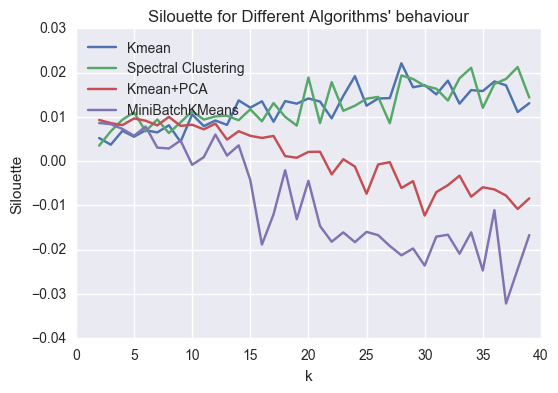

In [25]:
compare_cluster_tfs(tf_df)

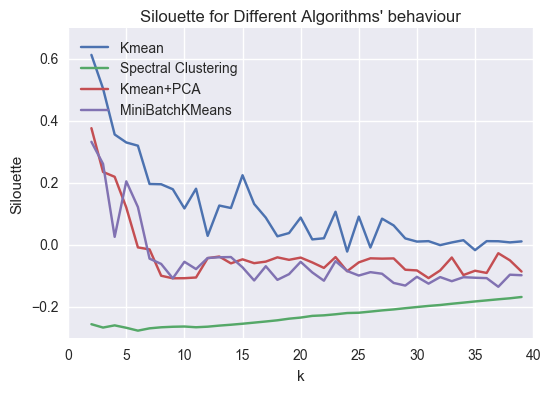

In [26]:
compare_cluster_tfs(nbow_df)

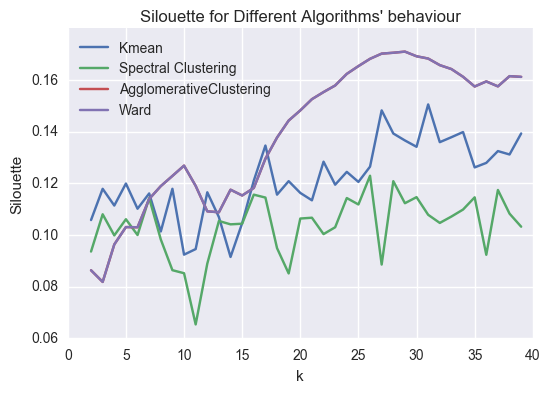

In [30]:
compare_cluster(dtm_lsa)

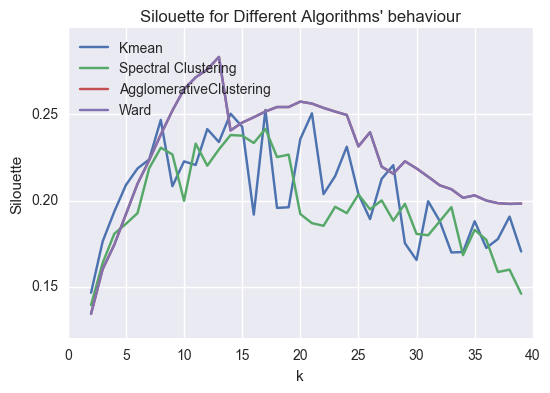

In [35]:
compare_cluster(dtm_nmf)

### TOPIC MODELING WITH NMF

In [50]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [55]:
import numpy as np
import numpy as np  # a conventional alias

import sklearn.feature_extraction.text as text
vectorizer = text.CountVectorizer(stop_words=stop_words)
dtm = vectorizer.fit_transform(all_body)
vocab = np.array(vectorizer.get_feature_names())
from sklearn import decomposition
n_topics = 12
n_top_words = 20
clf = decomposition.NMF(n_components=num_topics, random_state=1)
doctopic = clf.fit_transform(dtm)

topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:n_top_words]
    topic_words.append([vocab[i] for i in word_idx])
    
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)


headline = np.asarray(all_hd)
doctopic_orig = doctopic.copy()
num_groups = len(set(headline))
doctopic_grouped = np.zeros((num_groups, n_topics))
for i, name in enumerate(sorted(set(headline))):
    doctopic_grouped[i, :] = np.mean(doctopic[headline == name, :], axis=0)
    
doctopic = doctopic_grouped   
df=pd.DataFrame(doctopic)
threshold=0.3
print ("\nTopics in NMF model")

for i in xrange(n_topics):
    t0=df[df[i]>=threshold].index.values.tolist()
    
    print ("_____________________________________________")
    print ("TOPIC",i)
    print (topic_words[i])
    for j in t0:
        num=int(j)
        name=all_hd[num]
        print (j,tags1[j],tags2[j],":",name)



Topics in NMF model
_____________________________________________
TOPIC 0
[u'sex', u'men', u'life', u'women', u'even', u'way', u'god', u'felt', u'nakedness', u'fall', u'need', u'live', u'new', u'example', u'children', u'well', u'problem', u'still', u'eve', u'creation']
13 Desire nan : Associating desire with sin is something irrational. sex is a basic instinct like the need for food 
60 Sex nan : God created men as endowed with eternal life. When life is eternal, the procreation of new life thro
_____________________________________________
TOPIC 1
[u'marriage', u'ancient', u'virtue', u'social', u'proper', u'sexuality', u'based', u'sexual', u'scripture', u'order', u'rational', u'two', u'interpretation', u'economics', u'believers', u'gods', u'ethnicity', u'ignorant', u'people', u'matter']
2 Slaves Women : Sadly, none of what we read was new or a surprise to me.  I was fully aware of how women and slaves 
3 Sex Slaves : What surprised me most about ancient ideas of marriage was that the

In [56]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 12
n_top_words = 15
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,ngram_range=(1,1),
                                max_features=5000,tokenizer=tokenize,
                                stop_words=stop_words)

tf = tf_vectorizer.fit_transform(all_body)

print("Fitting LDA models with tf features, ")
lda = LatentDirichletAllocation(n_topics=n_topics)

lda.fit(tf)

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

ps=[]
word_topics=[]
for topic_idx, topic in enumerate(lda.components_):

     word_topics.append(" ".join([tf_feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))  
p=lda.perplexity(tf)
ps.append(p)


Fitting LDA models with tf features, 


/Users/nai/anaconda/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)



Topics in LDA model:
Topic #0:
marry sex wom thought christian seem slav issu wif com man property ev outsid espec
Topic #1:
sex slav wom act sin way ev men marry peopl christian mal ear interest partn
Topic #2:
marry conceiv many diff context jew think tim paul discus sex agr god pas soc
Topic #3:
marry sex would surpr slav real rel property tim right fath aw issu stil way
Topic #4:
slav slavery mal serv learn today fem mast egypt ba marry peopl giv shal last
Topic #5:
today jew influ slav context christian ear paul ev new many seem tim rom pop
Topic #6:
sex lik marry sin god tim paul elit ear pract jes liv heav said ba
Topic #7:
conceiv cult also sad king among scripture peopl interpret feel sex marry wel ind body
Topic #8:
sex tim men chang surpr wom difficul u rul understand tak enjoy past teach lif
Topic #9:
sex marry surpr ant wom pas rel partn act discus view believ lif rom virtu
Topic #10:
elit philosoph act easy slav evid com though point mor teach judg tru le prop
Topic #11:

## 4. Similarity Check with Golden Label 

In [158]:

def eval_similarity(df):
    matrix=df.as_matrix()
    cutoffs=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    cut_score={}
    scores=[]
    for cutoff in cutoffs:
        loc=0
        cor=0
        mis=0
        for i in xrange(88):
            for j in xrange(88):
                v=matrix[i,j]
                if v > cutoff:
                    c=1
                else:
                    c=0

                if c == y[loc]:
                    cor+=1

                else: 
                    mis+=1
                loc+=1
        total=cor+mis        
        cut_score[cutoff]=float(cor)/float(total)  
        scores.append(float(cor)/float(total)  )
        print (cutoff, float(cor)/float(total))
    return scores

tfidf similarity

In [119]:
sim=cosine_similarity(tf_df)
similarity = np.asarray(np.asmatrix(tf_df) * np.asmatrix(tf_df).T)
tfidfsim_df=pd.DataFrame(sim)
tfidfsim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,1.000000,0.103625,0.062425,0.178761,0.164491,0.120112,0.061919,0.165623,0.133073,0.066463,...,0.134451,0.093081,0.077561,0.174375,0.028009,0.162535,0.150668,0.123083,0.075022,0.081733
1,0.103625,1.000000,0.057561,0.036201,0.057228,0.153870,0.045610,0.023098,0.078013,0.082929,...,0.052619,0.006180,0.000000,0.053993,0.050181,0.061885,0.015915,0.036209,0.080399,0.000000
2,0.062425,0.057561,1.000000,0.085875,0.139389,0.069784,0.093694,0.064493,0.055847,0.069547,...,0.025057,0.067670,0.024435,0.024155,0.014385,0.057649,0.041989,0.100600,0.018228,0.057285
3,0.178761,0.036201,0.085875,1.000000,0.011981,0.135110,0.032763,0.070130,0.144848,0.084525,...,0.040273,0.048531,0.074147,0.195916,0.063917,0.161451,0.125999,0.124783,0.012849,0.056492
4,0.164491,0.057228,0.139389,0.011981,1.000000,0.000000,0.034456,0.031261,0.068938,0.053030,...,0.000000,0.114019,0.086161,0.056912,0.000000,0.060877,0.028328,0.113226,0.078618,0.031563


In [159]:
tfidf_scores=eval_similarity(tfidfsim_df)

0.1 0.605113636364
0.2 0.667097107438
0.3 0.667613636364
0.4 0.667613636364
0.5 0.668130165289
0.6 0.668388429752
0.7 0.668388429752
0.8 0.668388429752
0.9 0.668388429752


nbow similarity

In [121]:
sim=cosine_similarity(nbow_df)
similarity = np.asarray(np.asmatrix(nbow_df) * np.asmatrix(nbow_df).T)
nbowsim_df=pd.DataFrame(sim)
nbowsim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,1.000000,0.146805,0.128757,0.339417,0.229786,0.183866,0.123854,0.237322,0.275813,0.148675,...,0.180216,0.210090,0.143267,0.277133,0.113715,0.290929,0.279975,0.240990,0.114288,0.183435
1,0.146805,1.000000,0.131559,0.055048,0.083853,0.219179,0.115045,0.057735,0.117423,0.151911,...,0.085249,0.022361,0.000000,0.117985,0.064550,0.110096,0.011352,0.051299,0.097312,0.000000
2,0.128757,0.131559,1.000000,0.096561,0.196116,0.109847,0.151351,0.101274,0.109045,0.133235,...,0.029907,0.117670,0.042796,0.059131,0.056614,0.096561,0.039825,0.134976,0.034139,0.099627
3,0.339417,0.055048,0.096561,1.000000,0.030773,0.224071,0.137215,0.095346,0.349812,0.181186,...,0.093856,0.196946,0.241747,0.352578,0.213201,0.363636,0.324949,0.367109,0.021427,0.156326
4,0.229786,0.083853,0.196116,0.030773,1.000000,0.000000,0.064312,0.064550,0.092670,0.084921,...,0.000000,0.200000,0.109109,0.075378,0.000000,0.061546,0.025384,0.172062,0.130558,0.031750


In [160]:
nbow_score=eval_similarity(nbowsim_df)

0.1 0.480888429752
0.2 0.611570247934
0.3 0.665805785124
0.4 0.667355371901
0.5 0.667871900826
0.6 0.668130165289
0.7 0.668388429752
0.8 0.668388429752
0.9 0.668388429752


lsa similraity

In [123]:
sim=cosine_similarity(dtm_lsa)
similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T)
lsasim_df=pd.DataFrame(sim)
lsasim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,1.000000,0.326903,0.539517,0.716859,0.757601,0.426182,0.174509,0.645549,0.423404,0.409954,...,0.700390,0.708323,0.499657,0.721542,0.555063,0.642818,0.477486,0.610662,0.385689,0.466961
1,0.326903,1.000000,0.502908,0.019553,0.384508,0.602727,0.257913,0.351994,0.189046,0.512892,...,0.470861,0.130350,0.067829,0.172192,0.190077,0.126406,-0.155485,0.129182,0.255683,0.111299
2,0.539517,0.502908,1.000000,0.424545,0.466074,0.550022,0.405346,0.650110,0.250601,0.302967,...,0.586676,0.370146,0.400895,0.382083,0.657686,0.352094,0.058427,0.347348,0.136688,0.256068
3,0.716859,0.019553,0.424545,1.000000,0.368956,0.371989,0.190415,0.395140,0.475327,0.335328,...,0.481913,0.714946,0.747732,0.747591,0.665358,0.798498,0.675850,0.851577,0.194956,0.451029
4,0.757601,0.384508,0.466074,0.368956,1.000000,0.273537,0.222510,0.674885,0.267572,0.264047,...,0.511927,0.553151,0.305629,0.325958,0.407640,0.440995,0.156610,0.376668,0.418881,0.160388


In [161]:
lsa_score=eval_similarity(lsasim_df)

0.1 0.374741735537
0.2 0.434659090909
0.3 0.484245867769
0.4 0.535898760331
0.5 0.585743801653
0.6 0.621384297521
0.7 0.64333677686
0.8 0.663739669421
0.9 0.667355371901


lsa similarity

In [125]:
sim=cosine_similarity(dtm_nmf)
nmfsim_df=pd.DataFrame(sim)
nmfsim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,1.000000,0.155383,0.689259,0.860270,0.779054,0.190519,0.006619,0.848072,0.000000,0.155087,...,0.315674,0.517523,0.637569,0.427722,0.813963,0.648431,0.358709,0.623054,0.147804,0.350291
1,0.155383,1.000000,0.385977,0.000000,0.052918,0.935842,0.000000,0.226049,0.000000,0.238260,...,0.839382,0.000000,0.000000,0.379038,0.000000,0.141804,0.000000,0.000000,0.522270,0.000000
2,0.689259,0.385977,1.000000,0.643295,0.631887,0.414010,0.219213,0.753896,0.000000,0.138711,...,0.419877,0.501818,0.685444,0.175192,0.807484,0.370470,0.000805,0.507252,0.284829,0.268663
3,0.860270,0.000000,0.643295,1.000000,0.727540,0.077305,0.006757,0.781155,0.039786,0.081710,...,0.185990,0.719018,0.820594,0.341958,0.799244,0.649792,0.366159,0.868823,0.132951,0.332861
4,0.779054,0.052918,0.631887,0.727540,1.000000,0.158523,0.000000,0.847470,0.000000,0.068589,...,0.202744,0.532767,0.673787,0.127476,0.758985,0.285373,0.000000,0.558062,0.312564,0.304352


In [162]:
nmf_score=eval_similarity(nmfsim_df)

0.1 0.481146694215
0.2 0.536157024793
0.3 0.569989669421
0.4 0.586002066116
0.5 0.603047520661
0.6 0.619834710744
0.7 0.632747933884
0.8 0.647469008264
0.9 0.662190082645


Use Neural Network to train similarity

In [172]:
def split2traintest(df):
    comb_vec=[]
    for i in xrange(88):
        for j in xrange(88):
            listone=df[i]
            listtwo=df[j]
            mergedlist = listone + listtwo
            comb_vec.append(mergedlist)
    X_TR=comb_vec[:2000]
    y_TR=gold_label[:2000]
    X_TE=comb_vec[2000:]
    y_TE=gold_label[2000:]


    X_train=np.asarray(X_TR)
    y_train=np.asarray(y_TR)
    X_test=np.asarray(X_TE)
    y_test=np.asarray(y_TE)
    comb_vec=np.asarray(comb_vec)
    return X_train, y_train,X_test,y_test,comb_vec

In [174]:
from sknn.mlp import Regressor, Layer
def nn_regressors(X_train, y_train,comb_vec):
    nn = Regressor(
        layers=[
            Layer("Rectifier", units=100),
            Layer("Linear")],
        learning_rate=0.02,
        n_iter=10)

    nn.fit(X_train, y_train)

    y_predall = nn.predict(comb_vec)
    pred_matrix=np.zeros((88,88))
    l=0
    for i in xrange(88):
        for j in xrange(88):
            pred_matrix[i,j]=y_predall[l]
            l+=1
    nn_preddf=pd.DataFrame(pred_matrix)  
    return nn_preddf

In [177]:
X_train, y_train,X_test,y_test,comb_vec=split2traintest(tf_df)
nn_predtf=nn_regressors(X_train, y_train,comb_vec)
nn_predtf.head()
print ("Neural Network Regressor")
nnr_tfscore=eval_similarity(nn_predtf)

Neural Network Regressor
0.1 0.501291322314
0.2 0.64243285124
0.3 0.689695247934
0.4 0.686725206612
0.5 0.678719008264
0.6 0.669292355372
0.7 0.66270661157
0.8 0.658832644628
0.9 0.657541322314


In [184]:
X_train, y_train,X_test,y_test,comb_vec=split2traintest(nbow_df)
nn_predtf=nn_regressors(X_train, y_train,comb_vec)
nn_predtf.head()
print ("Neural Network Regressor")
nnr_nbowscore=eval_similarity(nn_predtf)

Neural Network Regressor
0.1 0.502582644628
0.2 0.60020661157
0.3 0.667484504132
0.4 0.70493285124
0.5 0.730759297521
0.6 0.730630165289
0.7 0.720816115702
0.8 0.704545454545
0.9 0.691890495868


In [181]:
X_train, y_train,X_test,y_test,comb_vec=split2traintest(nbow_df)
nn_predtf=nn_regressors(X_train, y_train,comb_vec)
nn_predtf.head()
print ("Neural Network Regressor")
nnr_nbowscore=eval_similarity(nn_predtf)

Neural Network Regressor
0.1 0.535769628099
0.2 0.626291322314
0.3 0.697830578512
0.4 0.723140495868
0.5 0.733341942149
0.6 0.731534090909
0.7 0.713326446281
0.8 0.694989669421
0.9 0.679752066116


In [182]:
X_train, y_train,X_test,y_test,comb_vec=split2traintest(dtm_lsa)
nn_predtf=nn_regressors(X_train, y_train,comb_vec)
nn_predtf.head()
print ("Neural Network Regressor")
nnr_lsascore=eval_similarity(nn_predtf)

Neural Network Regressor
0.1 0.531766528926
0.2 0.62409607438
0.3 0.680914256198
0.4 0.697830578512
0.5 0.702350206612
0.6 0.695247933884
0.7 0.686337809917
0.8 0.675103305785
0.9 0.668646694215


In [183]:
X_train, y_train,X_test,y_test,comb_vec=split2traintest(dtm_nmf)
nn_predtf=nn_regressors(X_train, y_train,comb_vec)
nn_predtf.head()
print ("Neural Network Regressor")
nnr_nmfscore=eval_similarity(nn_predtf)

Neural Network Regressor
0.1 0.577479338843
0.2 0.647727272727
0.3 0.693569214876
0.4 0.702608471074
0.5 0.700800619835
0.6 0.688016528926
0.7 0.678719008264
0.8 0.669679752066
0.9 0.663868801653


In [135]:
from sknn.mlp import Classifier, Layer

nn = Classifier(
    layers=[
        Layer("Rectifier", units=100),
        Layer("Rectifier", units=50),
        Layer("Rectifier", units=10),
        Layer("Softmax")],
    learning_rate=0.001,
    n_iter=50)
nn.fit(X_train, y_train)

Classifier(batch_size=1, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: units=100, name=u'hidden0', frozen=False>,
      hidden1=<sknn.nn.Layer `Rectifier`: units=50, name=u'hidden1', frozen=False>,
      hidden2=<sknn.nn.Layer `Rectifier`: units=10, name=u'hidden2', frozen=False>,
      layers=[<sknn.nn.Layer `Rectifier`: units=100, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Rectifier`: units=50, name=u'hidden1', frozen=False>, <sknn.nn.Layer `Rectifier`: units=10, name=u'hidden2', frozen=False>, <sknn.nn.Layer `Softmax`: units=2, name=u'output', frozen=False>],
      learning_momentum=0.9, learning_rate=0.001, learning_rule=u'sgd',
      loss_type=None, n_iter=50, n_stable=10, normalize=None,
      output=<sknn.nn.Layer `Softmax`: units=2, name=u'output', frozen=False>,
      parameters=None, random_state=None, regularize=None, valid_set=None,
      valid_size=0.0, verbose=None, warning=None, weight_decay=None)

In [78]:
y_predall2 = nn.predict(comb_pred)
score = nn.score(comb_pred, y)
print (score)
pred_matrix2=np.zeros((88,88))
l=0
for i in xrange(88):
    for j in xrange(88):
        pred_matrix2[i,j]=y_predall2[l]
        l+=1
 nn_preddf2=pd.DataFrame(pred_matrix2)

[(7744, 2)]
[(7744, 2)]
0.686337809917


In [79]:
nn_matrix=nn_preddf.as_matrix()

In [164]:
print ("Neural Network Classifier")
nnc_score=eval_similarity(nn_preddf2)


Neural Network Classifier
0.1 0.686337809917
0.2 0.686337809917
0.3 0.686337809917
0.4 0.686337809917
0.5 0.686337809917
0.6 0.686337809917
0.7 0.686337809917
0.8 0.686337809917
0.9 0.686337809917


[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.3747417355371901, 0.4346590909090909, 0.484245867768595, 0.5358987603305785, 0.5857438016528925, 0.6213842975206612, 0.6433367768595041, 0.6637396694214877, 0.6673553719008265]


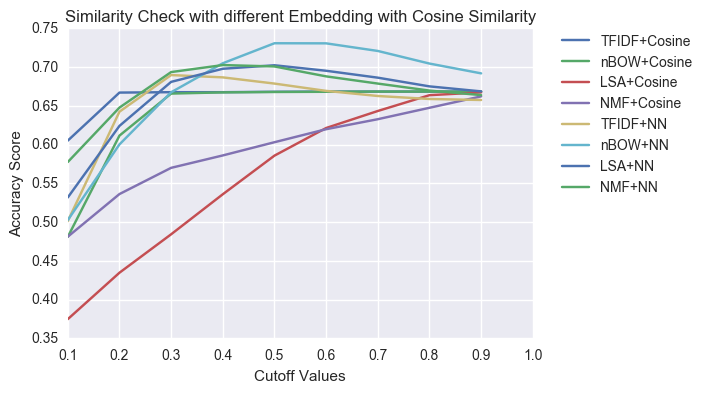

In [186]:
import operator


x=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
s1=tfidf_scores
s2=nbow_score
s3=lsa_score
s4=nmf_score
s5=nnr_tfscore
s6=nnr_nbowscore
s7=nnr_lsascore
s8=nnr_nmfscore
print (x)
print (s3)
plt.plot(x,s1)
plt.plot(x,s2)
plt.plot(x,s3)
plt.plot(x,s4)
plt.plot(x,s5)
plt.plot(x,s6)
plt.plot(x,s7)
plt.plot(x,s8)
plt.ylabel("Accuracy Score")
plt.xlabel("Cutoff Values")
plt.title("Similarity Check with different Embedding with Cosine Similarity")
plt.legend(['TFIDF+Cosine', 'nBOW+Cosine', 'LSA+Cosine','NMF+Cosine','TFIDF+NN', 'nBOW+NN', 'LSA+NN','NMF+NN'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
